## Analyse d'une campagne de marketing d'une banque

Réalisée par Abdoulaye SALL, Data Analyst


### 1. Compréhension des données

#### Importation des librairies

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import xgboost as xgb
import joblib

# Initialisation des paramètres
random_state = 42  # Graine aléatoire pour la reproductibilité

#### Chargement et exploration des données

In [34]:
# Chargement du jeu de données
df = pd.read_csv("bank.csv")


In [35]:
# Convertir les valeurs infinies en NaN dans votre DataFrame
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [36]:
import warnings

# Ignorer le FutureWarning spécifique
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated", category=FutureWarning)

#### Dictionnaire des données:

- age : Âge du client

- job : Profession du client 
- marital : Situation familiale du client
- education : Niveau d'éducation du client
- default : A des crédits en défaut de paiement ?
- housing : Si le client a un prêt immobilier
- loan : A un prêt personnel
- balance : Solde individuel du client
- contact : Type de communication 
- month : Mois du dernier contact
- day : Jour de la semaine du dernier contact
- duration : Durée du dernier contact, en secondes
- campaign : Nombre de contacts effectués pendant cette campagne pour ce client
- pdays : Nombre de jours écoulés depuis le dernier contact du client lors d'une précédente campagne
- previous : Nombre de contacts effectués avant cette campagne pour ce client
- poutcome : Résultat de la précédente campagne marketing
- y : Le client a-t-il souscrit un dépôt à terme

#### Analyse Descriptive

In [37]:
# Aperçu du jeu de données
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [38]:
#Description de la base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [39]:
# Calculer l'âge médian
age_median = df['campaign'].median()

# Afficher l'âge médian
print("L'âge médian dans le jeu de données est de :", age_median)

L'âge médian dans le jeu de données est de : 2.0


### 2. Analyse exploratoire des données


In [40]:
# Analyse descriptive des variables numériques
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


#### Analyse univariée

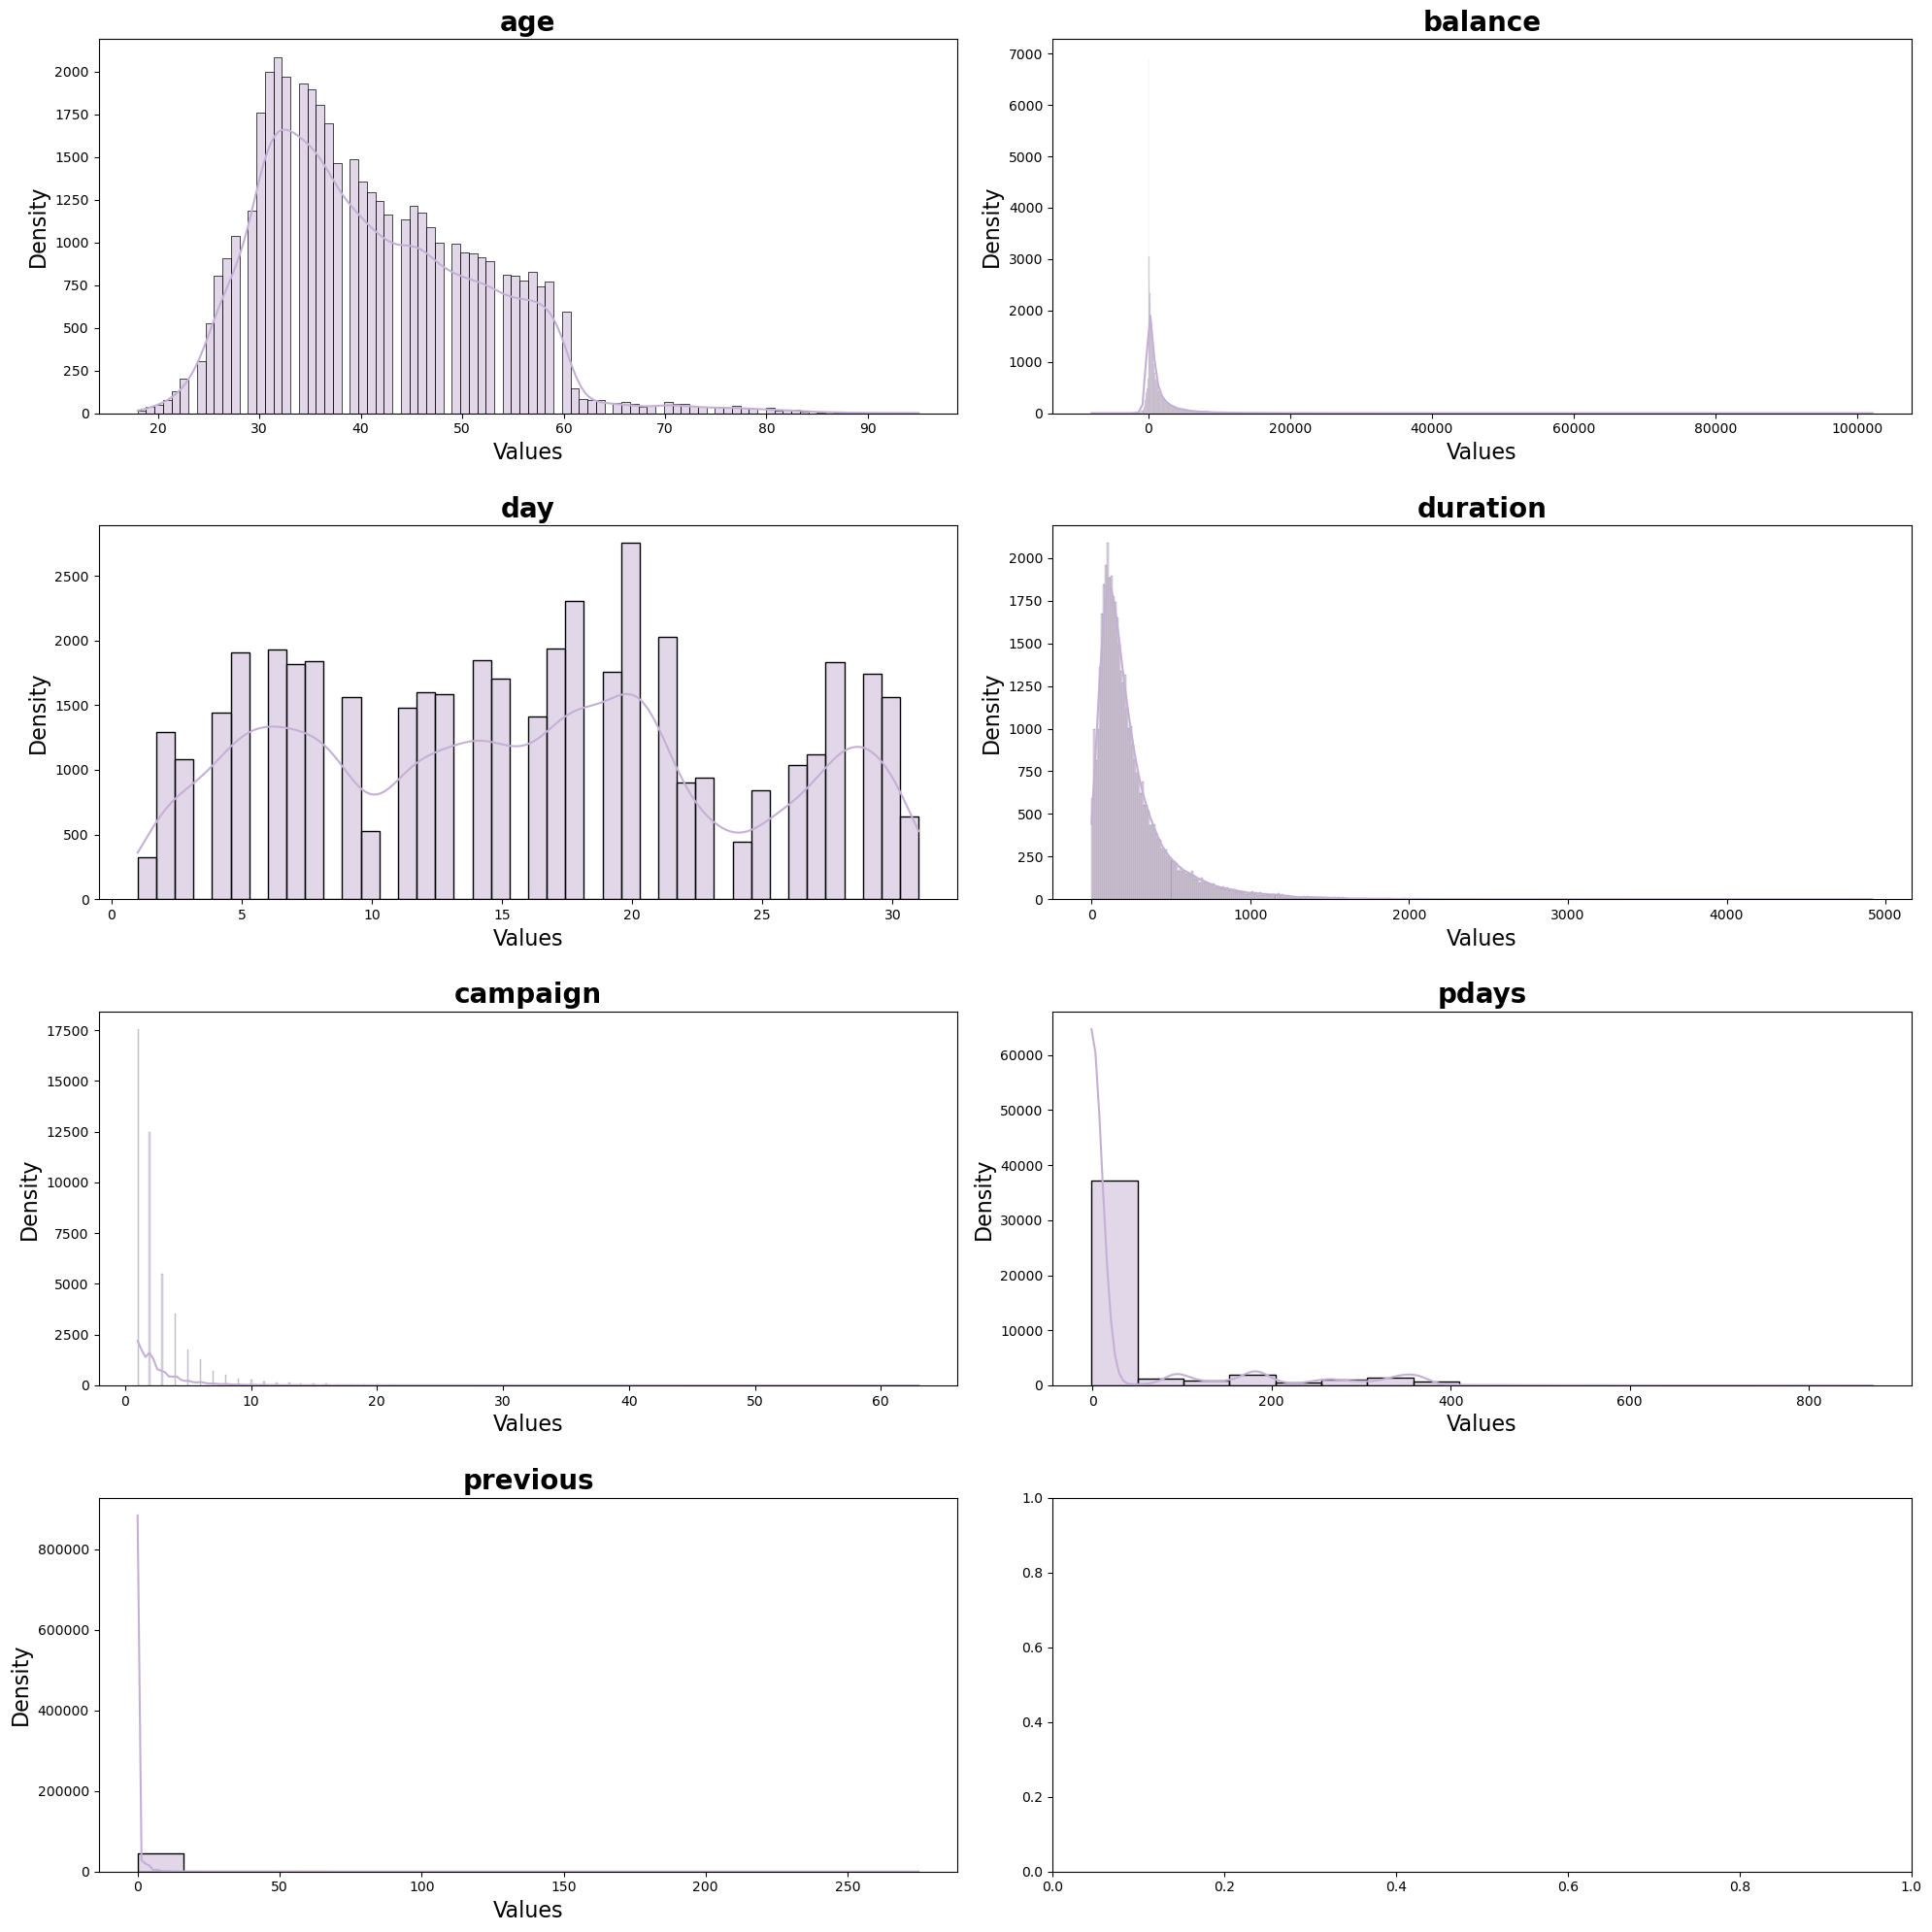

In [41]:
# Distribution des variables numériques

# Liste des colonnes à visualiser
columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Création de la figure et des axes
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
ax = ax.flatten()

# Itération sur chaque colonne
for i in range(7):
    # Création d'un histogramme de distribution avec courbe de densité pour la colonne actuelle
    sns.histplot(df[columns[i]], ax=ax[i], color='#c5b0d5', kde=True)
    
    # Définition du titre de l'axe avec le nom de la colonne
    ax[i].set_title(columns[i], fontsize=20, fontweight='bold')
    
    # Définition des étiquettes des axes x et y
    ax[i].set_xlabel('Values', fontsize=16)
    ax[i].set_ylabel('Density', fontsize=16)

# Ajustement de la disposition des sous-graphiques
plt.tight_layout()

# Ajustement de l'espacement vertical entre les sous-graphiques
plt.subplots_adjust(hspace=0.3)

# Affichage de la figure
plt.show()


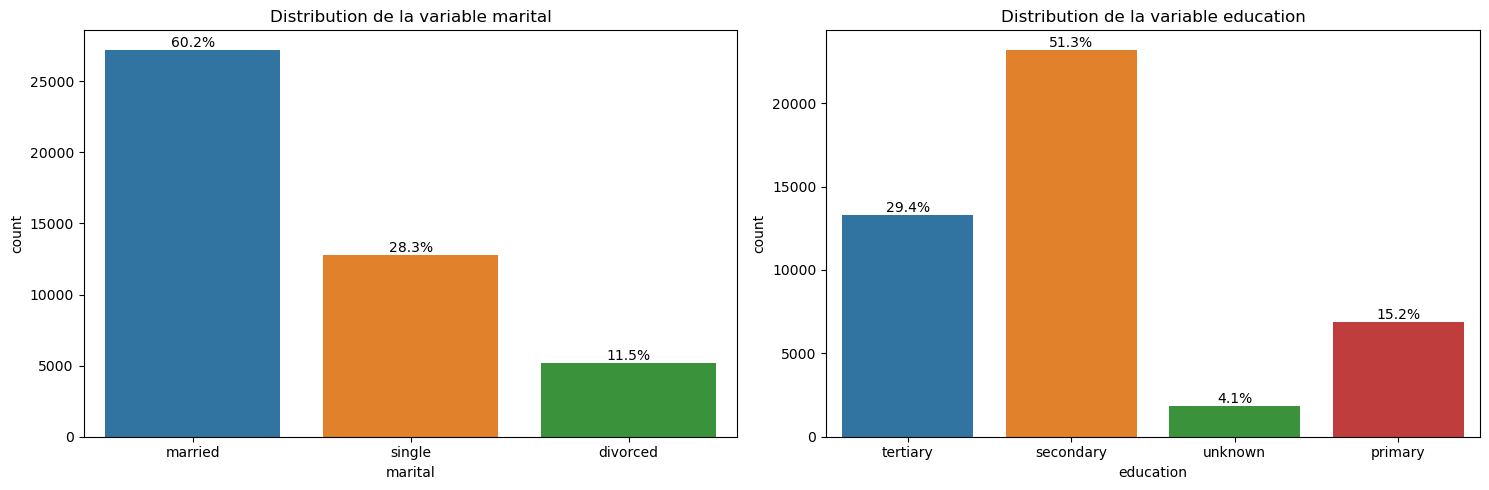

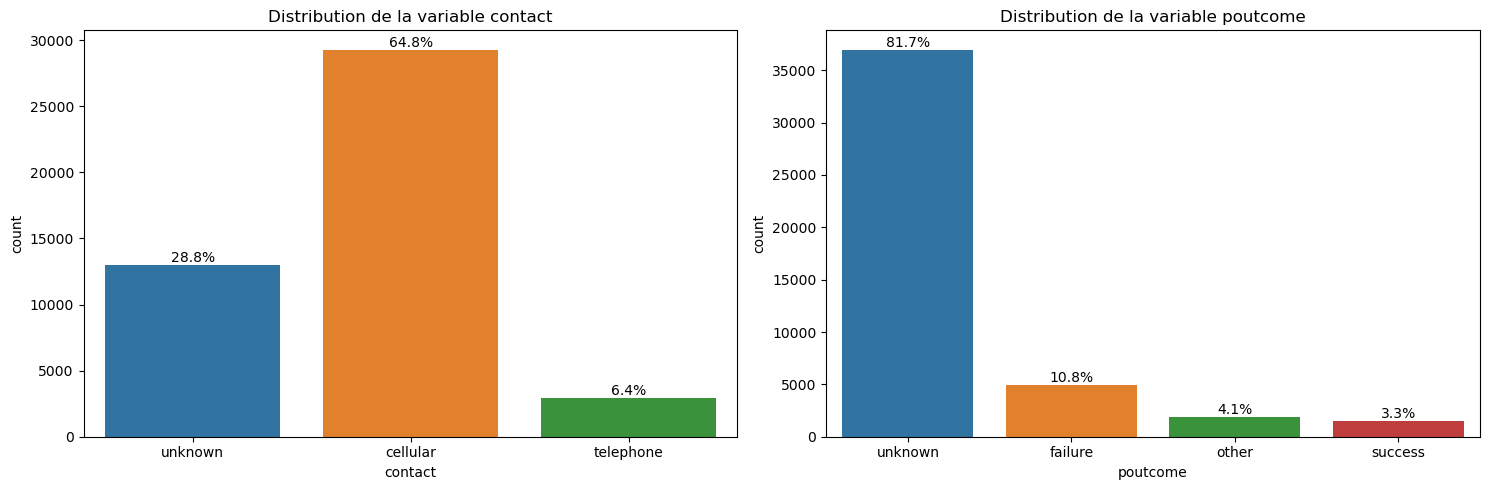

In [42]:
# Variables catégorielles en barres
categorical_vars = ['marital', 'education','contact','poutcome']
# Définir le nombre de variables catégorielles par figure
cat_variables_par_figure = 2

# Calculer le nombre total de figures nécessaires
nb_cat_figures = len(categorical_vars) // cat_variables_par_figure
if len(categorical_vars) % cat_variables_par_figure != 0:
    nb_cat_figures += 1

# Itérer sur les figures
for f in range(nb_cat_figures):
    # Calculer les indices des variables pour cette figure
    start_idx = f * cat_variables_par_figure
    end_idx = min((f + 1) * cat_variables_par_figure, len(categorical_vars))
    cat_vars_for_figure = categorical_vars[start_idx:end_idx]

    # Créer une nouvelle figure avec les axes nécessaires
    fig, axes = plt.subplots(1, len(cat_vars_for_figure), figsize=(15, 5))
    
    # Itérer sur les variables pour cette figure
    for i, var in enumerate(cat_vars_for_figure):
        sns.countplot(data=df, x=var, ax=axes[i])
        axes[i].set_title(f"Distribution de la variable {var}")
        # Calculer le pourcentage par rapport au total de la variable
        total_counts = df[var].count()
        for p in axes[i].patches:
            height = p.get_height()
            percentage = height / total_counts * 100
            axes[i].annotate(f"{percentage:.1f}%", (p.get_x() + p.get_width()/2, height), ha="center", va="bottom")

    # Ajuster la disposition de la figure
    plt.tight_layout()
    plt.show()



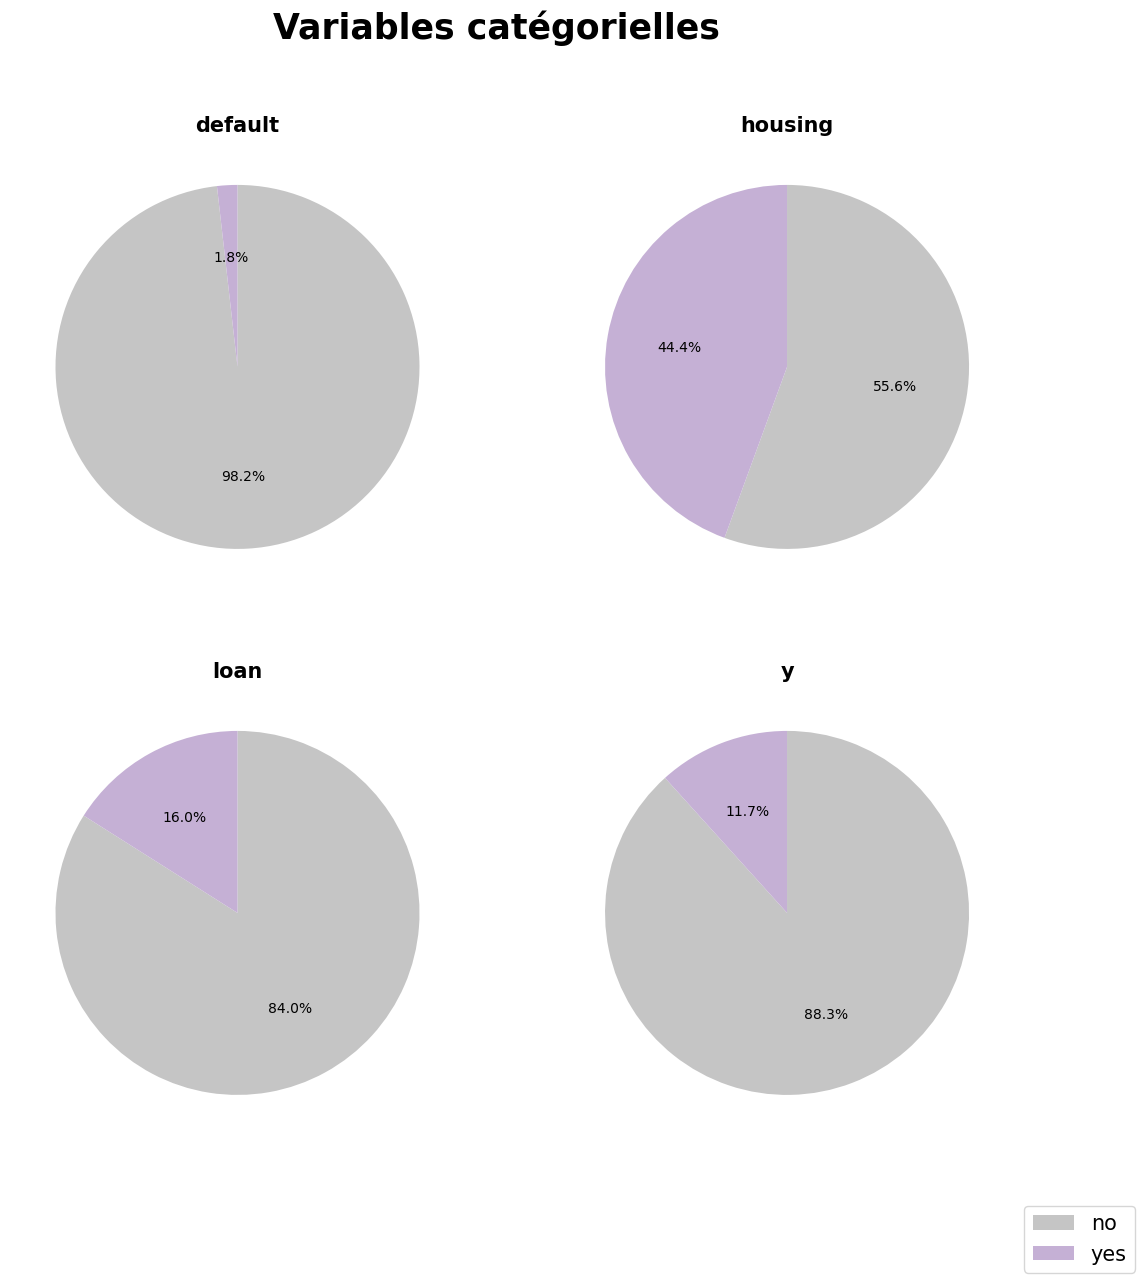

In [43]:
# Variables catégorielles en secteur
binary_list = ['default', 'housing', 'loan', 'y']

# Couleurs pour les réponses 'no' et 'yes'
colors = ['#c5c5c5', '#c5b0d5']

# Création de la figure et des axes
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
ax = ax.flatten()

# Itération sur les variables binaires
for i, binary_column in enumerate(binary_list):
    # Calcul des comptages de valeurs pour chaque réponse binaire
    value_counts = df[binary_column].value_counts()
    
    # Création d'un diagramme en secteurs avec les comptages de valeurs
    ax[i].pie(value_counts, colors=colors, startangle=90, counterclock=False, autopct='%1.1f%%')
    
    # Définition du titre de l'axe avec le nom de la variable binaire
    ax[i].set_title(binary_column, fontsize=15, fontweight='bold')

# Libellés pour la légende
labels = ['no', 'yes']

# Ajout de la légende à la figure
legend = fig.legend(labels, loc="lower right", fontsize=15)

# Titre global de la figure
fig.suptitle("Variables catégorielles", fontsize=25, fontweight='bold')

# Affichage de la figure
plt.show()


#### Analyse bivarié

Voici quelques paires de variables pertinentes pour une analyse bivariée :

1. **Age et Souscription au dépôt à terme (y)** 

2. **Balance et Souscription au dépôt à terme (y)** 

3. **Résultat de la précédente campagne marketing (poutcome) et Souscription au dépôt à terme (y)**


Ces paires de variables vous permettront d'explorer différentes facettes de nos données et de comprendre comment chacune est associée à la probabilité de souscrire à un dépôt à terme.

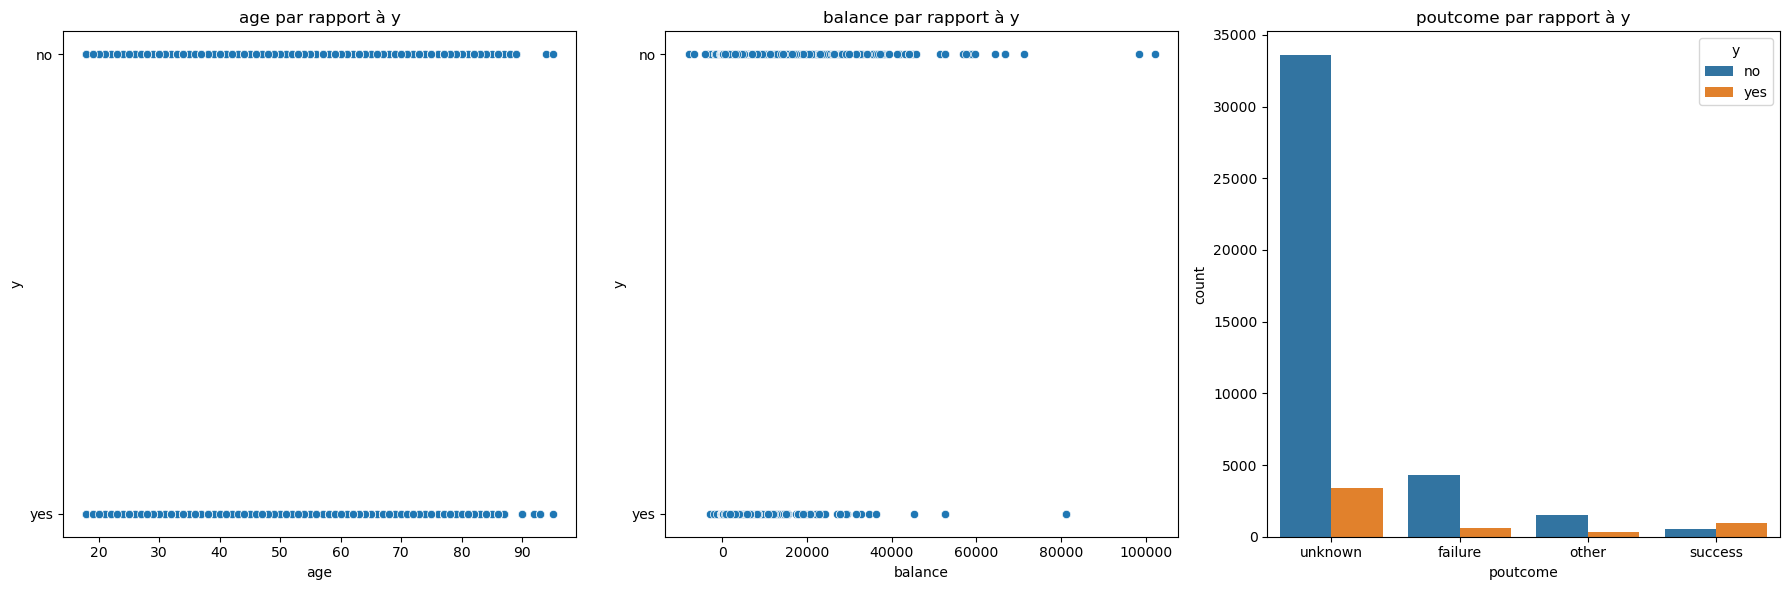

In [44]:
# Créer une figure avec 3 lignes et 2 colonnes pour placer les graphiques
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Variables à analyser
variables_num = ['age', 'balance']
variables_cat = ['poutcome']

# Itérer sur les variables numériques et afficher les nuages de points
for i, var in enumerate(variables_num):
    sns.scatterplot(data=df, x=var, y='y', ax=axes[i])
    axes[i].set_title(f"{var} par rapport à y")

# Itérer sur les variables catégorielles et afficher les types de graphiques suggérés
for i, var in enumerate(variables_cat):
    sns.countplot(data=df, x=var, hue='y', ax=axes[i+len(variables_num)])
    axes[i+len(variables_num)].set_title(f"{var} par rapport à y")

# Ajuster la disposition
plt.tight_layout()
plt.show()


#### Matrice de corrélation

La matrice de corrélation est un outil essentiel pour explorer et comprendre les relations entre les variables de votre ensemble de données, ce qui nous aide à prendre des décisions éclairées lors de la modélisation des données

In [45]:
mat_variables_num = ['age', 'balance', 'campaign']

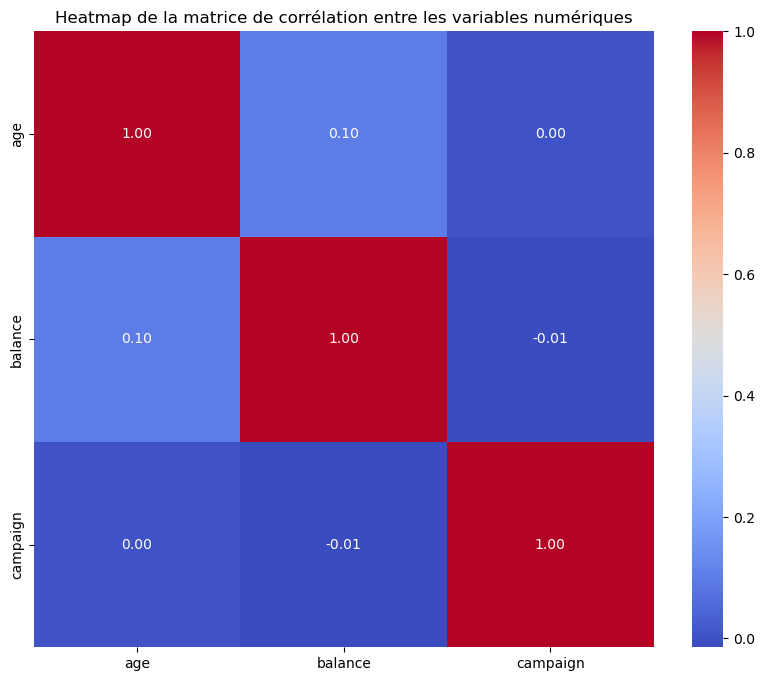

In [46]:
# Calculer la matrice de corrélation
correlation_matrix = df[mat_variables_num].corr()

# Créer une heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title("Heatmap de la matrice de corrélation entre les variables numériques")
plt.show()


### 3. Préparation des données

###### Dans cette étape, nous allons nettoyer les données en supprimant/remplaçant les valeurs manquantes/aberrantes, transformer les données si nécessaire (encodage, normalisation, etc.) et sélectionner/formater les variables pertinentes.

In [47]:
# Vérification des valeurs manquantes
print(df.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [48]:
#Catégorisation des variable
df['default'] = df['default'].apply(lambda x: 1 if x=='yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x=='yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x=='yes' else 0)
df['y'] = df['y'].apply(lambda x: 1 if x=='yes' else 0)

print(df['default'].unique())
print(df['housing'].unique())
print(df['loan'].unique())
print(df['y'].unique())

[0 1]
[1 0]
[0 1]
[0 1]


In [49]:
#Encodage des variables
cols_to_dummy = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
dummies = pd.get_dummies(df[cols_to_dummy])
dummies_to_keep = pd.DataFrame(dummies.sum()/df.shape[0]).sort_values(0, ascending=False).head(50).index.tolist()
df = df[[x for x in df.columns if x not in cols_to_dummy]].join(dummies[dummies_to_keep])

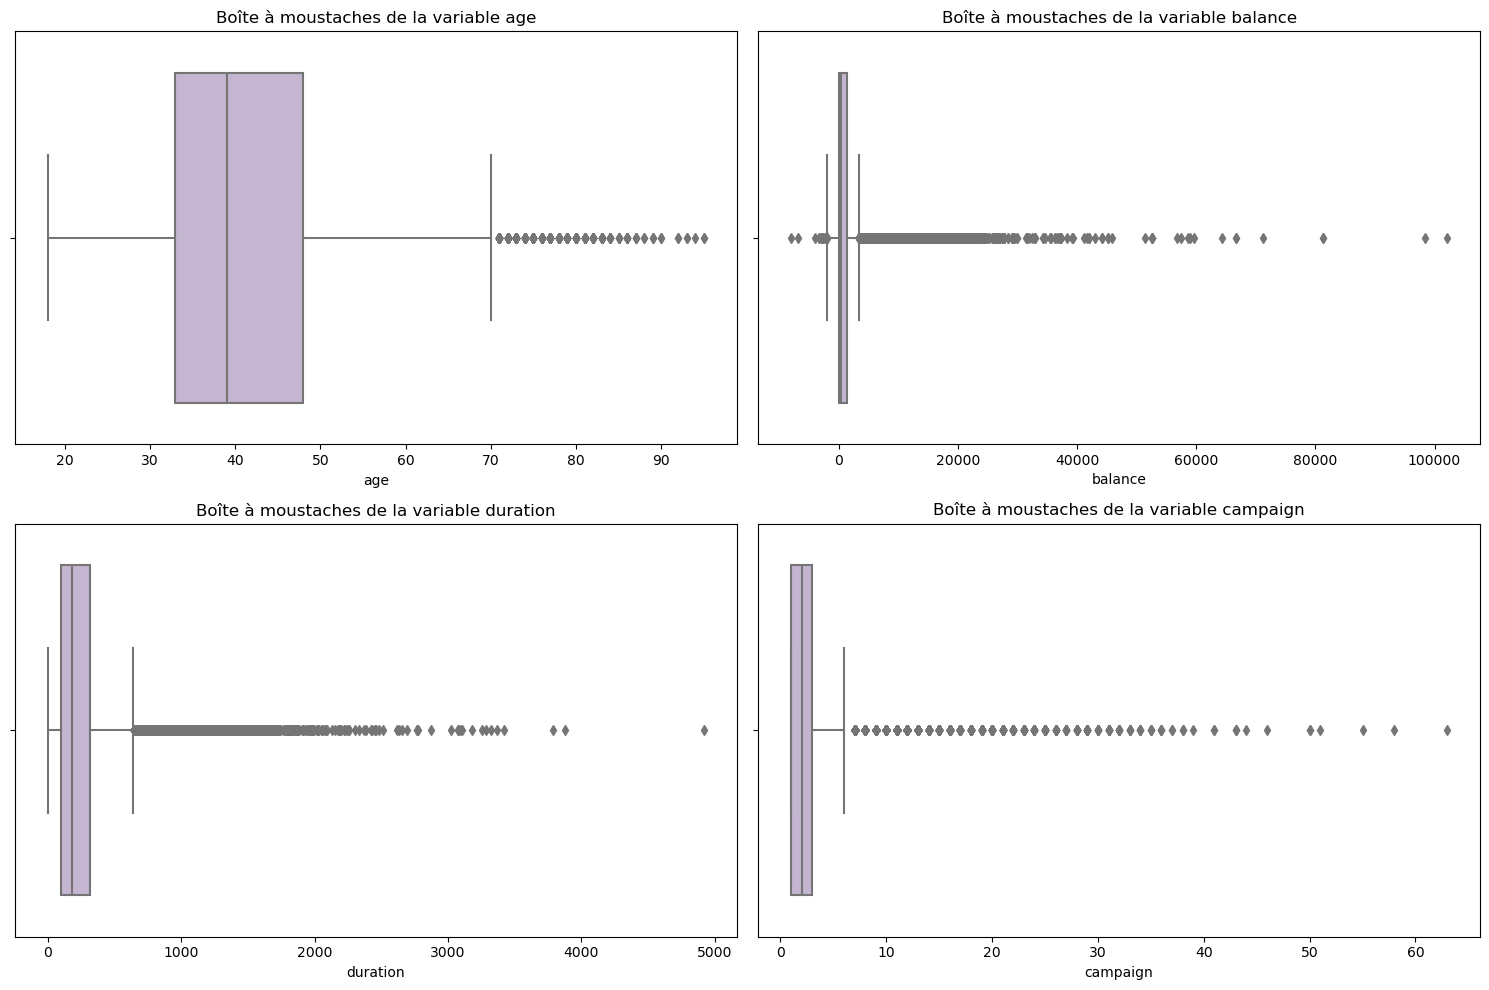

In [50]:
# Gestion des valeurs abbérantes
variables = ['age', 'balance', 'duration', 'campaign']

# Calcul du nombre de lignes nécessaire en fonction du nombre de variables
num_rows = (len(variables) + 1) // 2

# Création des sous-graphiques avec deux graphiques par ligne
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))

# Aplatir les axes pour simplifier l'itération
axes = axes.flatten()

# Itérer sur les variables
for i, var in enumerate(variables):
    # Créer un graphique de boîte à moustaches pour la variable actuelle
    sns.boxplot(data=df, x=var, color="#c5b0d5", ax=axes[i])
    
    # Définir le titre du graphique
    axes[i].set_title(f"Boîte à moustaches de la variable {var}")

# Masquer les axes supplémentaires s'il y en a
for j in range(len(variables), len(axes)):
    axes[j].axis('off')

# Ajuster la disposition
plt.tight_layout()

# Afficher la figure
plt.show()

### Tests de normalité

In [51]:
from scipy.stats import shapiro, kstest
for var in variables:
    # Test de Shapiro-Wilk
    stat_shapiro, p_value_shapiro = shapiro(df[var])
    print(f"Test de Shapiro-Wilk pour {var}:")
    print(f"Statistique: {stat_shapiro}")
    print(f"p-value: {p_value_shapiro}")

    # Interprétation du p-value de Shapiro-Wilk
    if p_value_shapiro > 0.05:
        print(f"L'hypothèse de normalité n'est pas rejetée (p-value > 0.05).")
    else:
        print(f"L'hypothèse de normalité est rejetée (p-value <= 0.05).")

    # Test de Kolmogorov-Smirnov
    stat_ks, p_value_ks = kstest(df[var], 'norm')
    print(f"\nTest de Kolmogorov-Smirnov pour {var}:")
    print(f"Statistique: {stat_ks}")
    print(f"p-value: {p_value_ks}")

    # Interprétation du p-value de Kolmogorov-Smirnov
    if p_value_ks > 0.05:
        print(f"L'hypothèse de normalité n'est pas rejetée (p-value > 0.05).")
    else:
        print(f"L'hypothèse de normalité est rejetée (p-value <= 0.05).")

    print("\n------------------------------------------------------")

Test de Shapiro-Wilk pour age:
Statistique: 0.9605457782745361
p-value: 0.0
L'hypothèse de normalité est rejetée (p-value <= 0.05).

Test de Kolmogorov-Smirnov pour age:
Statistique: 1.0
p-value: 0.0
L'hypothèse de normalité est rejetée (p-value <= 0.05).

------------------------------------------------------
Test de Shapiro-Wilk pour balance:
Statistique: 0.45717018842697144
p-value: 0.0
L'hypothèse de normalité est rejetée (p-value <= 0.05).

Test de Kolmogorov-Smirnov pour balance:
Statistique: 0.8298637446659435
p-value: 0.0
L'hypothèse de normalité est rejetée (p-value <= 0.05).

------------------------------------------------------
Test de Shapiro-Wilk pour duration:
Statistique: 0.7269952297210693
p-value: 0.0
L'hypothèse de normalité est rejetée (p-value <= 0.05).

Test de Kolmogorov-Smirnov pour duration:
Statistique: 0.9997029066263848
p-value: 0.0
L'hypothèse de normalité est rejetée (p-value <= 0.05).

------------------------------------------------------
Test de Shapiro

C:\Users\hp\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Transformation logarithmique pour normaliser les données en Python : 

La transformation logarithmique est une autre méthode de normalisation des données qui peut être utile dans certains cas. 

Elle consiste à appliquer une fonction logarithme (base 10 ou base naturelle) à chaque valeur des données. 

###### Avantages: 

- Réduit l'asymétrie des données: La transformation logarithmique peut être particulièrement efficace pour normaliser les données qui présentent une distribution asymétrique positive, c'est-à-dire où les valeurs sont concentrées à gauche de la distribution et que la queue droite est plus longue. 

- Compresse la plage des valeurs: La transformation logarithmique peut comprimer la plage des valeurs des données, ce qui peut être utile pour certains algorithmes d'apprentissage automatique qui sont sensibles à l'échelle des données.

En principe chaque variable numérique sera transformée en son équivalent logarithmique.

La transformation est effectuée en ajoutant une constante (10 000) aux valeurs d'origine pour éviter les erreurs dues aux valeurs nulles ou négatives.

Les nouvelles colonnes sont nommées log_column pour chaque colonne d'origine, et les colonnes d'origine sont supprimées du DataFrame.

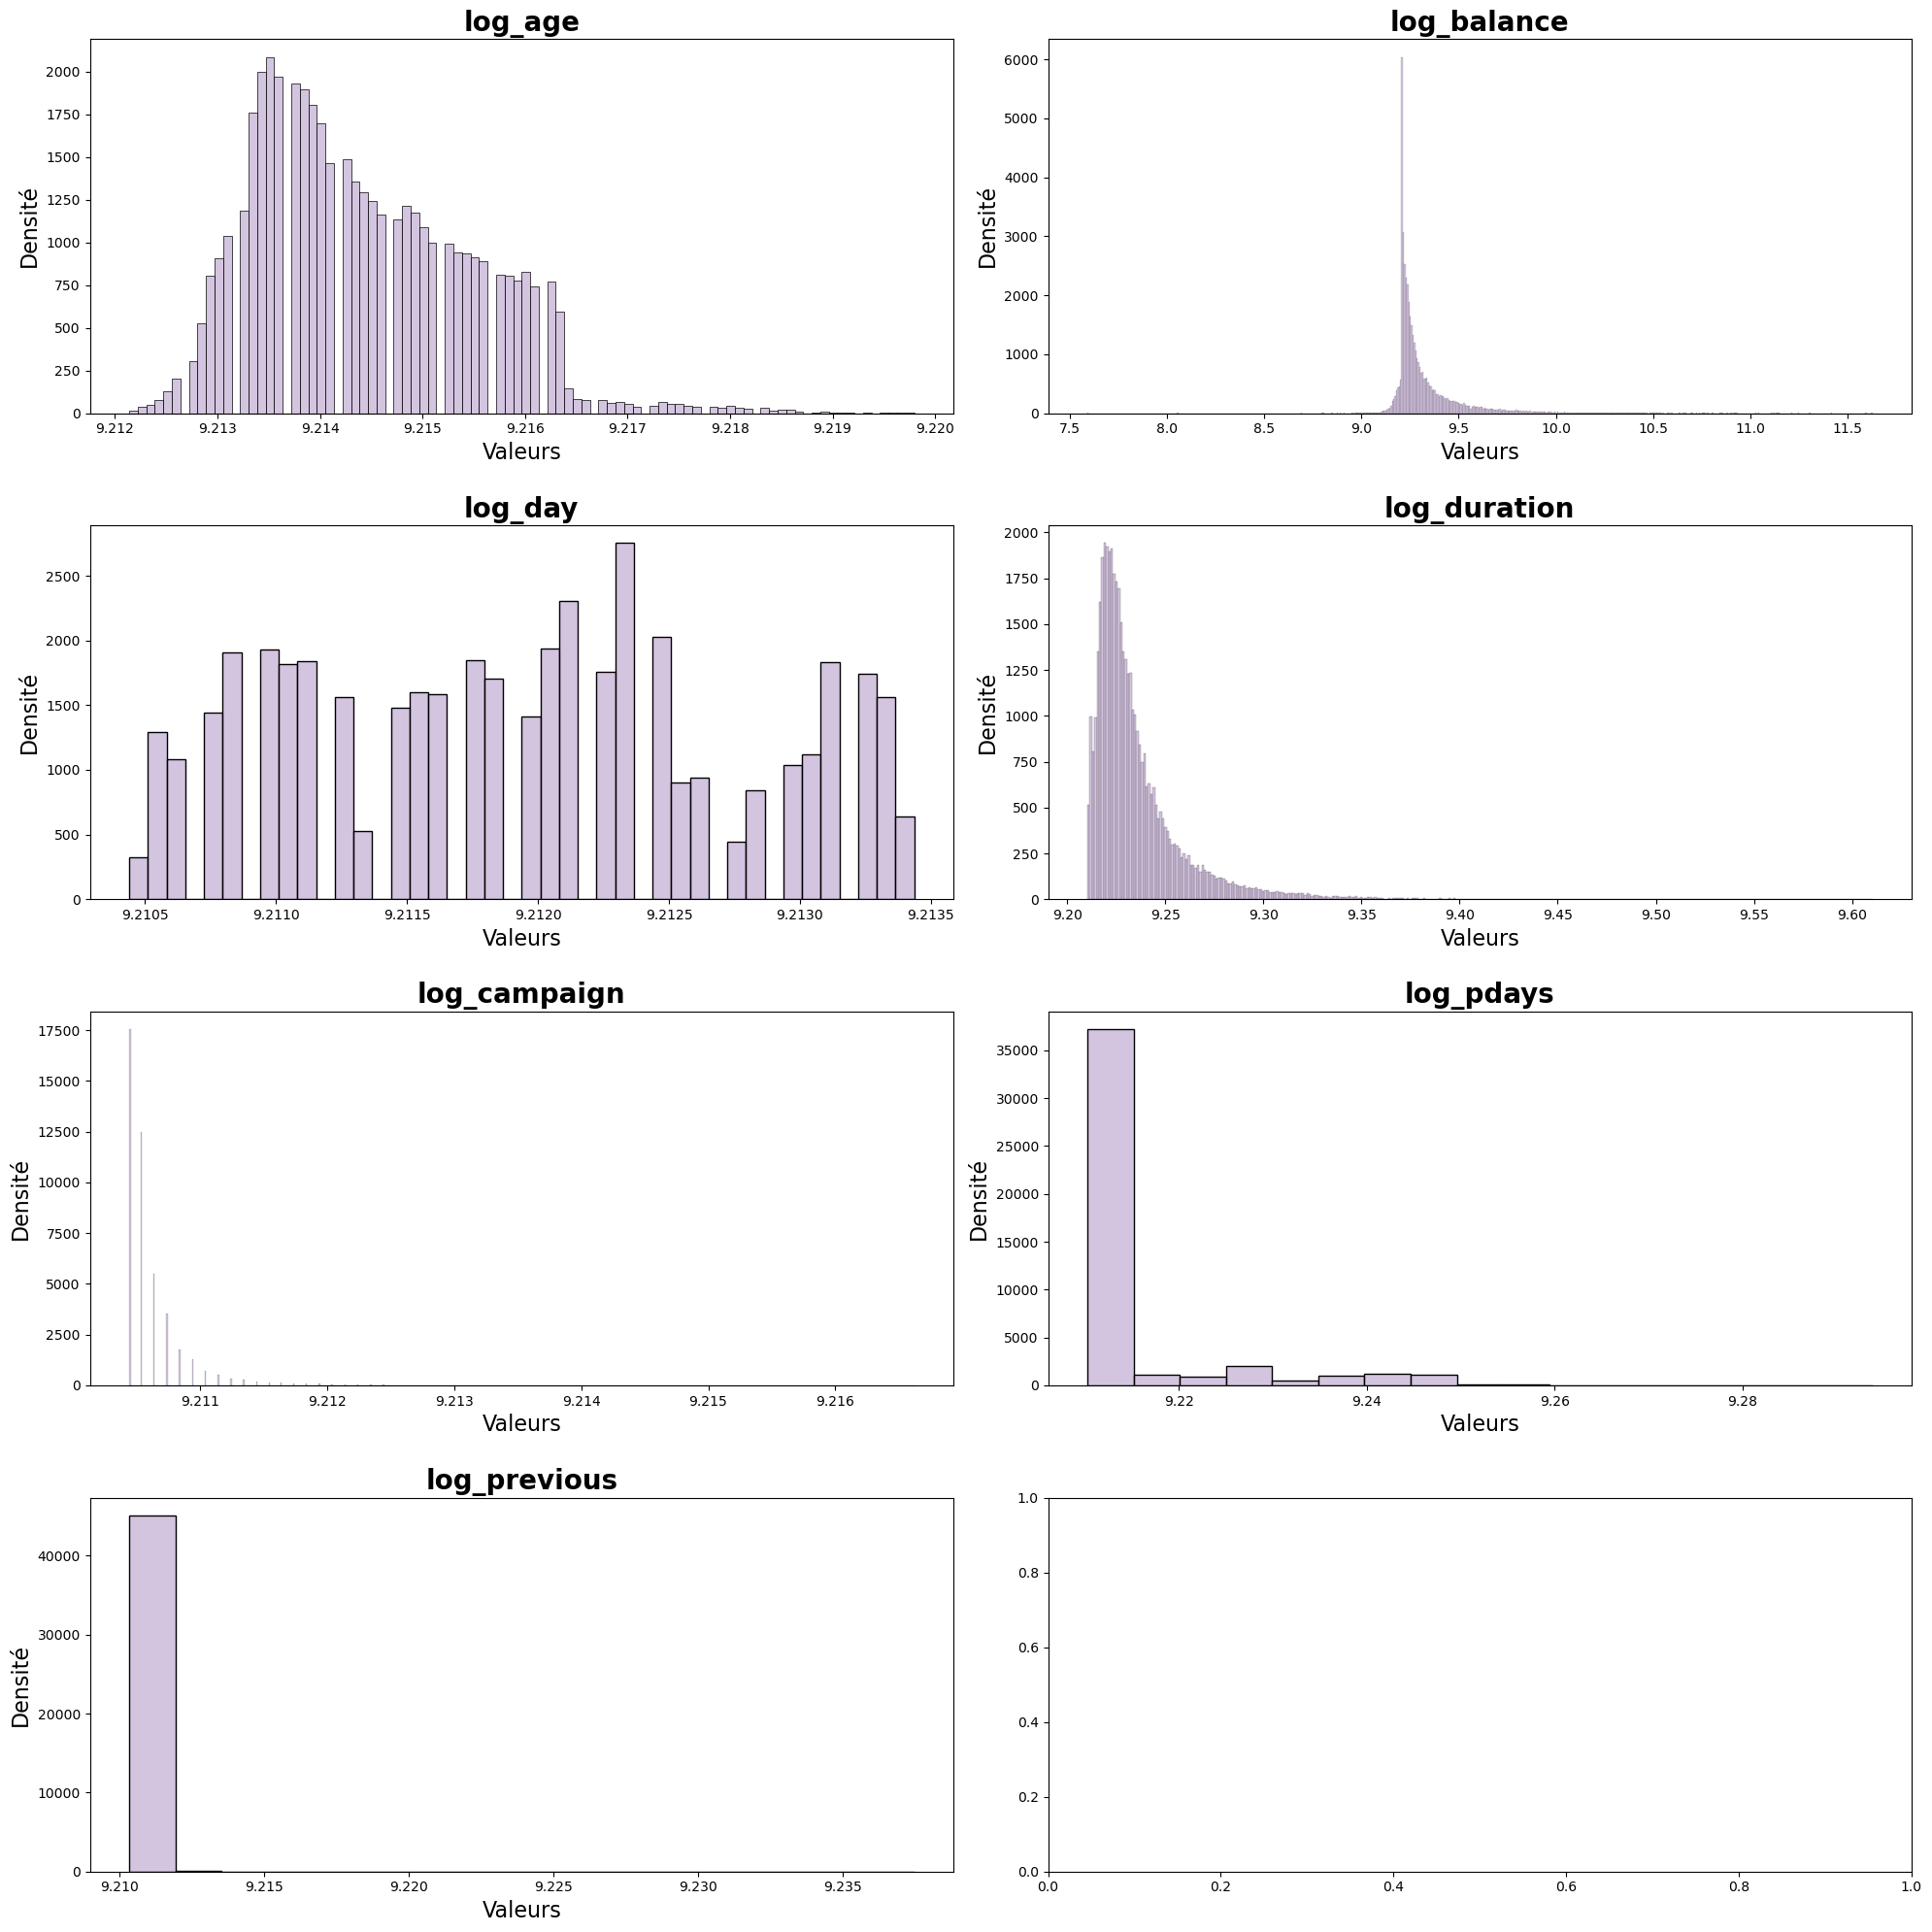

In [52]:
# Transformation logarithmique

# Liste des variables numériques
columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

log_columns = ['log_' + col for col in columns]

# Pour chaque colonne numérique, appliquer la transformation logarithmique avec ajout d'une constante
for column in columns:
    df['log_' + column] = np.log(df[column]+10000)
    # Supprimer les colonnes d'origine du DataFrame
    df = df.drop(columns = column, axis = 1)

# Créer une figure avec une grille de sous-graphiques (4 lignes, 2 colonnes)
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
ax = ax.flatten()

# Tracé des variables logarithmiques
for i in range(7):
    # Tracer la distribution de la variable logarithmique
    sns.histplot(df[log_columns[i]], ax=ax[i], color='#c5b0d5')
    # Définir le titre du graphique avec le nom de la variable logarithmique
    ax[i].set_title(log_columns[i], fontsize=20, fontweight='bold')
    # Ajouter une étiquette pour l'axe x
    ax[i].set_xlabel('Valeurs', fontsize=16)
    # Ajouter une étiquette pour l'axe y
    ax[i].set_ylabel('Densité', fontsize=16)

# Ajuster la disposition des sous-graphiques
plt.tight_layout()
# Ajuster l'espacement vertical entre les sous-graphiques
plt.subplots_adjust(hspace=0.3)
# Afficher les graphiques
plt.show()



In [53]:
df.isna().sum().sum()

0

In [54]:
df.shape

(45211, 49)

In [55]:
df

,default,housing,loan,y,poutcome_unknown,contact_cellular,marital_married,education_secondary,month_may,education_tertiary,...,month_mar,job_unknown,month_dec,log_age,log_balance,log_day,log_duration,log_campaign,log_pdays,log_previous
0,0,1,0,0,True,False,True,False,True,True,...,False,False,False,9.216124,9.404508,9.210840,9.236106,9.21044,9.210240,9.21034
1,0,1,0,0,True,False,False,True,True,False,...,False,False,False,9.214731,9.213236,9.210840,9.225328,9.21044,9.210240,9.21034
2,0,1,1,0,True,False,True,True,True,False,...,False,False,False,9.213635,9.210540,9.210840,9.217912,9.21044,9.210240,9.21034
3,0,1,0,0,True,False,True,False,True,False,...,False,False,False,9.215029,9.350624,9.210840,9.219498,9.21044,9.210240,9.21034
4,0,0,0,0,True,False,False,False,True,False,...,False,True,False,9.213635,9.210440,9.210840,9.229947,9.21044,9.210240,9.21034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0,0,0,1,True,True,True,False,False,True,...,False,False,False,9.215427,9.289614,9.212039,9.303557,9.21064,9.210240,9.21034
45207,0,0,0,1,True,True,False,False,False,False,...,False,False,False,9.217415,9.369820,9.212039,9.254931,9.21054,9.210240,9.21034
45208,0,0,0,1,False,True,True,True,False,False,...,False,False,False,9.217515,9.662371,9.212039,9.317130,9.21084,9.228573,9.21064
45209,0,0,0,0,True,False,True,True,False,False,...,False,False,False,9.216024,9.275004,9.212039,9.259892,9.21074,9.210240,9.21034


In [56]:
print(df.columns)

Index(['default', 'housing', 'loan', 'y', 'poutcome_unknown',
       'contact_cellular', 'marital_married', 'education_secondary',
       'month_may', 'education_tertiary', 'contact_unknown', 'marital_single',
       'job_blue-collar', 'job_management', 'job_technician', 'month_jul',
       'education_primary', 'month_aug', 'month_jun', 'marital_divorced',
       'job_admin.', 'poutcome_failure', 'job_services', 'month_nov',
       'month_apr', 'contact_telephone', 'month_feb', 'job_retired',
       'education_unknown', 'poutcome_other', 'job_self-employed',
       'poutcome_success', 'job_entrepreneur', 'month_jan', 'job_unemployed',
       'job_housemaid', 'job_student', 'month_oct', 'month_sep', 'month_mar',
       'job_unknown', 'month_dec', 'log_age', 'log_balance', 'log_day',
       'log_duration', 'log_campaign', 'log_pdays', 'log_previous'],
      dtype='object')


### 4. Modélisation

##### L'utilisation de techniques de sélection de variables automatiques peut être très plus efficace pour sélectionner les variables les plus importantes pour la prédiction

In [57]:
# Séparation de la variable cible y et de l'ensemble de caractéristiques X
X = df.drop('y', axis=1)  # X contient toutes les variables sauf la variable cible 'y'
y = df['y']  # y contient la variable cible 'y'

# Division des données en ensembles d'entraînement et de validation
# Les données sont divisées de manière stratifiée pour conserver la proportion de classes dans chaque ensemble
X_base, X_val, y_base, y_val = train_test_split(X, y, stratify=y, test_size=0.2)

# Utilisation de SMOTE pour équilibrer les données d'entraînement
smote = SMOTE()
X_base, y_base = smote.fit_resample(X_base, y_base)

# Division des données d'entraînement restantes en ensembles de test et de validation
# Les données sont à nouveau divisées de manière stratifiée
X_train, X_test, y_train, y_test = train_test_split(X_base, y_base, stratify=y_base, test_size=0.25)

In [58]:
# Fonction pour évaluer les modèles
def scores(model, show_colorbar=False):
    # Prédiction sur les données d'entraînement et de test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Affichage du score ROC AUC sur les données d'entraînement et de test
    print("Score ROC AUC sur les données d'entraînement : ", roc_auc_score(y_train, y_train_pred))
    print("Score ROC AUC sur les données de test : ", roc_auc_score(y_test, y_test_pred))
    
    # Création d'une figure pour afficher les matrices de confusion
    plt.figure(figsize=(15, 5))
    
    # Affichage de la matrice de confusion sur les données d'entraînement
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel('Étiquette prédite')
    plt.ylabel('Étiquette réelle')
    plt.title('Matrice de confusion sur les données d\'entraînement')
    if show_colorbar:
        plt.colorbar(fraction=0.046, pad=0.04)
        
    # Affichage de la matrice de confusion sur les données de test
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel('Étiquette prédite')
    plt.ylabel('Étiquette réelle')
    plt.title('Matrice de confusion sur les données de test')
    if show_colorbar:
        plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()


#### Algorithme de LogisticRegression

Score ROC AUC sur les données d'entraînement :  0.8852098836828112
Score ROC AUC sur les données de test :  0.8835252063300052


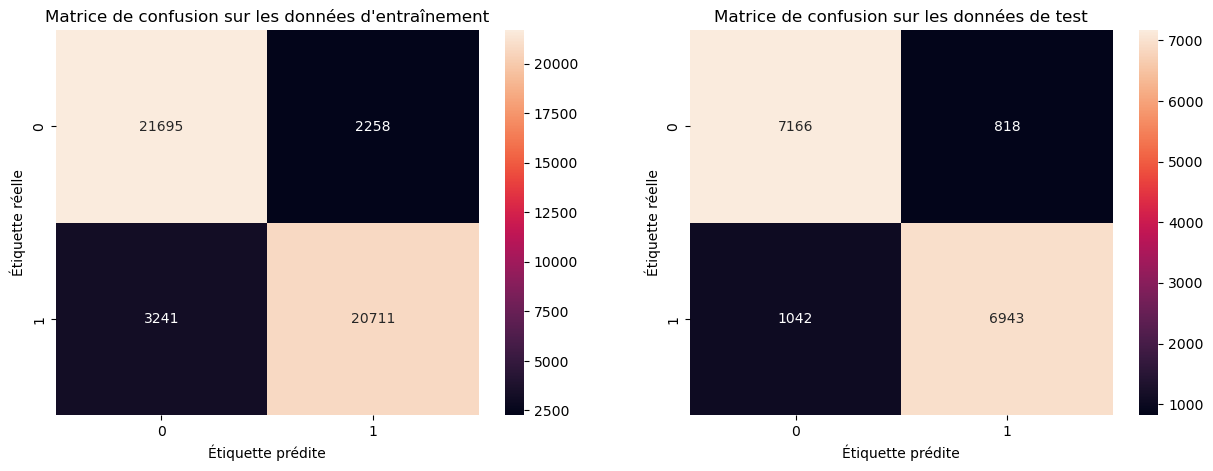

In [59]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
scores(log_reg)

#### Algorithme de DecisionTree

Score ROC AUC sur les données d'entraînement :  1.0
Score ROC AUC sur les données de test :  0.9055668083192057


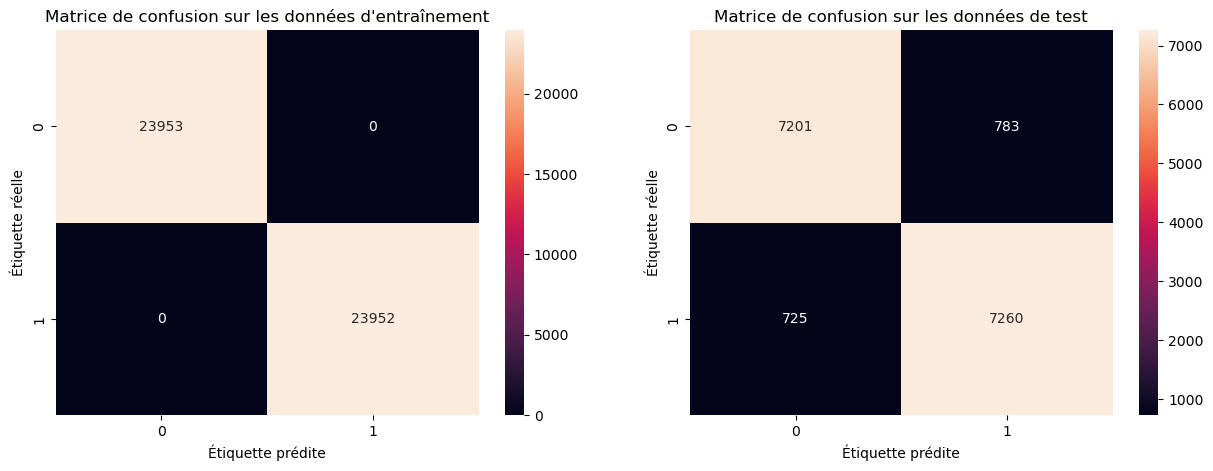

In [60]:
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, y_train)
scores(dec_tree)

#### Algorithme de RandomForest 

Score ROC AUC sur les données d'entraînement :  1.0
Score ROC AUC sur les données de test :  0.9442026115474532


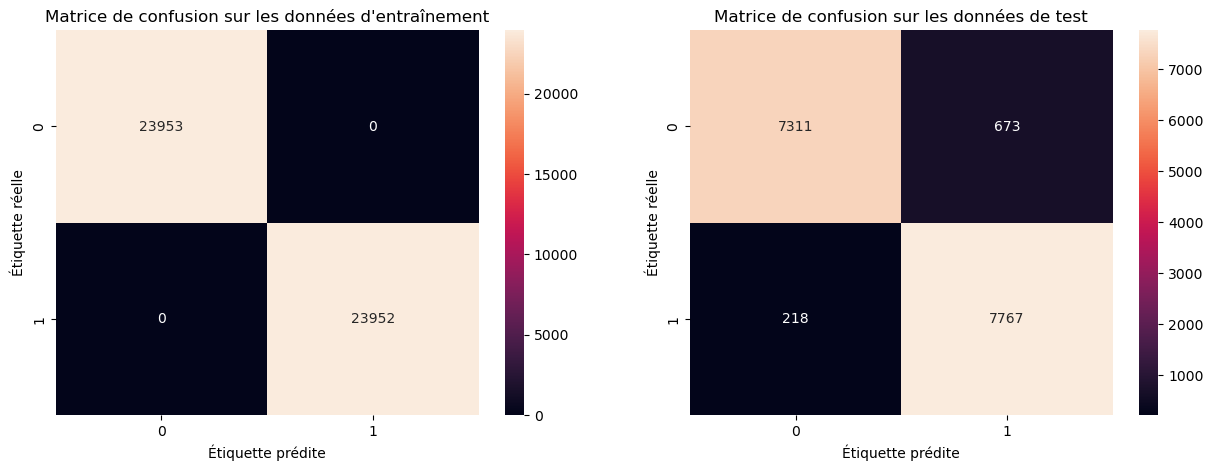

In [61]:
rand_for = RandomForestClassifier()
rand_for.fit(X_train, y_train)
scores(rand_for)

#### Algorithme de GradientBoostingClassifier

Score ROC AUC sur les données d'entraînement :  0.9128487321572549
Score ROC AUC sur les données de test :  0.9108259411747728


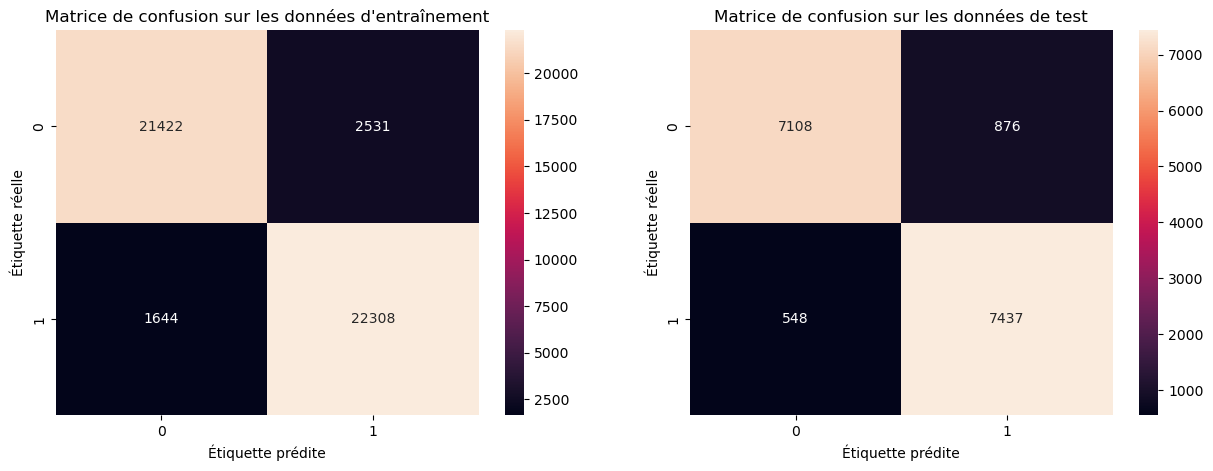

In [62]:
grad_boost = GradientBoostingClassifier()
grad_boost.fit(X_train, y_train)
scores(grad_boost)

In [63]:
# Liste des modèles de base à évaluer
base_models = [log_reg, dec_tree, rand_for, grad_boost]

# Boucle sur chaque modèle pour évaluation par validation croisée
for model in base_models:
    # Calcul des scores ROC AUC par validation croisée sur l'ensemble de données équilibré
    scores = cross_val_score(model, X_base, y_base, cv=5, scoring='roc_auc')
    
    # Affichage des résultats pour chaque modèle
    print('##' + str(model) + '##')
    print("Scores ROC AUC pour les 5 plis de validation croisée : ", scores)
    print("Score ROC AUC moyen : ", scores.mean())
    print("Écart-type des scores ROC AUC : ", scores.std())
    print('#########')

##LogisticRegression(max_iter=1000)##
Scores ROC AUC pour les 5 plis de validation croisée :  [0.90422037 0.96375102 0.96325267 0.96313683 0.96145424]
Score ROC AUC moyen :  0.9511630240247324
Écart-type des scores ROC AUC :  0.02348408537105686
#########
##DecisionTreeClassifier()##
Scores ROC AUC pour les 5 plis de validation croisée :  [0.83263477 0.9192191  0.91929338 0.91999793 0.91788007]
Score ROC AUC moyen :  0.9018050494708894
Écart-type des scores ROC AUC :  0.03459192260761895
#########
##RandomForestClassifier()##
Scores ROC AUC pour les 5 plis de validation croisée :  [0.97747061 0.99463571 0.9941022  0.99442975 0.99490346]
Score ROC AUC moyen :  0.9911083474700971
Écart-type des scores ROC AUC :  0.006823897098058812
#########
##GradientBoostingClassifier()##
Scores ROC AUC pour les 5 plis de validation croisée :  [0.93618794 0.97952509 0.97960367 0.97935429 0.98133622]
Score ROC AUC moyen :  0.9712014424377504
Écart-type des scores ROC AUC :  0.017521464277002165
#######

In [66]:
# Ajustement du modèle RandomForestClassifier sur l'ensemble de données d'entraînement équilibré
rand_for.fit(X_base, y_base)

# Prédiction des étiquettes de classe sur les données de validation
validation_pred = rand_for.predict(X_val)

# Calcul du score ROC AUC entre les étiquettes de classe prédites et les véritables étiquettes sur les données de validation
print(roc_auc_score(y_val, validation_pred))

# Calcul du score de précision du modèle RandomForestClassifier sur les données de validation
print(rand_for.score(X_val, y_val))


0.7862102619159506
0.8939511224151278


#### Sauvegarde du model RandomForestClassifier, le plus performant

In [67]:
import pickle

# Chemin où vous souhaitez enregistrer votre modèle
rand_for_model_path = 'rand_for_model.pkl'

# Enregistrement du modèle RandomForestClassifier
with open(rand_for_model_path, 'wb') as file:
    pickle.dump(rand_for, file)

print("Modèle RandomForestClassifier enregistré avec succès sous :", rand_for_model_path)


Modèle RandomForestClassifier enregistré avec succès sous : rand_for_model.pkl


#### Test du model sur des données

In [68]:
# Création des données pour un exemple de client

client_data = pd.DataFrame({
    'default': [0],
    'housing': [1],
    'loan': [0],
    'poutcome_unknown': [True],
    'contact_cellular': [True],
    'marital_married': [False],
    'education_secondary': [True],
    'month_may': [False],
    'education_tertiary': [False],
    'contact_unknown': [True],
    'marital_single': [False],
    'job_blue-collar': [True],
    'job_management': [True],
    'job_technician': [True],
    'month_jul': [False],
    'education_primary': [False],
    'month_aug': [True],
    'month_jun': [False],
    'marital_divorced': [True],
    'job_admin.': [False],
    'poutcome_failure': [False],
    'job_services': [False],
    'month_nov': [True],
    'month_apr': [True],
    'contact_telephone': [False],
    'month_feb': [False],
    'job_retired': [False],
    'education_unknown': [False],
    'poutcome_other': [False],
    'job_self-employed': [True],
    'poutcome_success': [True],
    'job_entrepreneur': [False],
    'month_jan': [True],
    'job_unemployed': [False],
    'job_housemaid': [False],
    'job_student': [True],
    'month_oct': [False],
    'month_sep': [True],
    'month_mar': [True],
    'job_unknown': [True],
    'month_dec': [True],
    'log_age': [9.216124],
    'log_balance': [9.316124],
    'log_day': [9.616124],
    'log_duration': [9.416124],
    'log_campaign': [9.236124],
    'log_pdays': [9.212544],
    'log_previous': [9.567124]
})

# Chargement du modèle pré-entraîné
model_path = 'rand_for_model.pkl'  # Chemin où votre modèle est enregistré
rand_for_model = joblib.load(model_path)

# Prédiction de la souscription du client
prediction = rand_for_model.predict(client_data)

if prediction[0] == 1:
    print("Le client est susceptible de souscrire un dépôt à terme.")
else:
    print("Le client n'est pas susceptible de souscrire un dépôt à terme.")


Le client est susceptible de souscrire un dépôt à terme.


### 5. Les ACP

In [146]:
# Importation de la classe PCA depuis le module sklearn.decomposition
pca = PCA(2)

# Réduction de la dimensionnalité des données d'entraînement en utilisant l'analyse en composantes principales (PCA)
X_train_pca = pca.fit_transform(X_train)

# Affichage de la forme des données d'entraînement après réduction de dimension
X_train_pca.shape

(47905, 2)

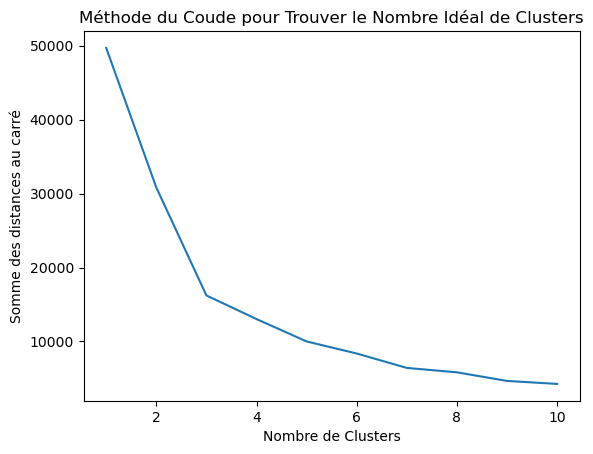

In [147]:
# Création d'une liste pour stocker la somme des distances au carré
sse = []

# Exécution de KMeans pour différentes valeurs de k
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train_pca)
    sse.append(kmeans.inertia_)

# Tracé de la somme des distances au carré
plt.plot(range(1, 11), sse)
plt.xlabel("Nombre de Clusters")
plt.ylabel("Somme des distances au carré")
plt.title("Méthode du Coude pour Trouver le Nombre Idéal de Clusters")
plt.show()


In [148]:
# Création d'une instance de KMeans avec 3 clusters
kmeans = KMeans(n_clusters=3)

# Ajustement du modèle aux données d'entraînement transformées par PCA
kmeans.fit(X_train_pca)

# Prédiction des clusters pour les données d'entraînement transformées par PCA
predictions = kmeans.predict(X_train_pca)

# Ajout des étiquettes de cluster aux données d'entraînement
X_train['cluster'] = predictions

In [149]:
# Transformation des données de test en utilisant PCA
X_test_pca = pca.transform(X_test)

# Ajustement du modèle KMeans aux données de test transformées par PCA
kmeans.fit(X_test_pca)

# Prédiction des clusters pour les données de test transformées par PCA
predictions = kmeans.predict(X_test_pca)

# Ajout des étiquettes de cluster aux données de test
X_test['cluster'] = predictions


In [150]:
# Initialisation du modèle RandomForestClassifier
rand_for = RandomForestClassifier()

# Ajustement du modèle sur les données d'entraînement
rand_for.fit(X_train, y_train)

# Prédiction sur les données d'entraînement
y_train_pred = rand_for.predict(X_train)

# Prédiction sur les données de test
y_test_pred = rand_for.predict(X_test)

# Calcul du score ROC AUC sur les données d'entraînement
print("Score ROC AUC sur les données d'entraînement : ", roc_auc_score(y_train, y_train_pred))

# Calcul du score ROC AUC sur les données de test
print("Score ROC AUC sur les données de test : ", roc_auc_score(y_test, y_test_pred))


Score ROC AUC sur les données d'entraînement :  1.0
Score ROC AUC sur les données de test :  0.9442031448620473


In [151]:
# Initialisation du modèle GradientBoostingClassifier
grad_boost = GradientBoostingClassifier()

# Ajustement du modèle sur les données d'entraînement
grad_boost.fit(X_train, y_train)

# Prédiction sur les données d'entraînement
y_train_pred = grad_boost.predict(X_train)

# Prédiction sur les données de test
y_test_pred = grad_boost.predict(X_test)

# Calcul du score ROC AUC sur les données d'entraînement
print("Score ROC AUC sur les données d'entraînement : ", roc_auc_score(y_train, y_train_pred))

# Calcul du score ROC AUC sur les données de test
print("Score ROC AUC sur les données de test : ", roc_auc_score(y_test, y_test_pred))

Score ROC AUC sur les données d'entraînement :  0.9116380801514523
Score ROC AUC sur les données de test :  0.9127675592261542


Score ROC AUC pour RandomForestClassifier sur les données de validation :  0.7843258212172398
Score ROC AUC pour GradientBoostingClassifier sur les données de validation :  0.8227523132338163


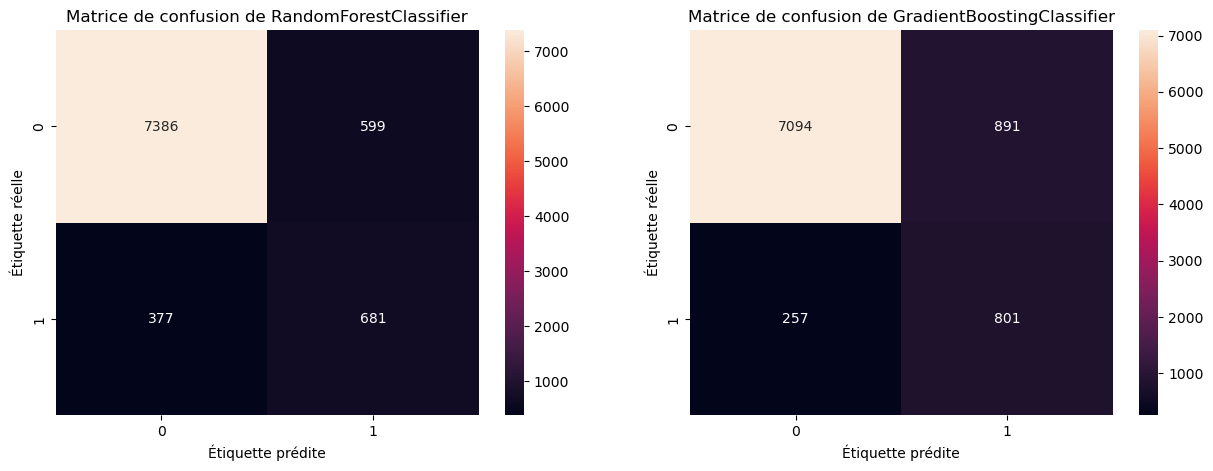

In [152]:
# Sur les données de validation
# Ajustement des modèles RandomForestClassifier et GradientBoostingClassifier sur l'ensemble des données d'entraînement équilibrées (X_base, y_base)
rand_for.fit(X_base, y_base)
grad_boost.fit(X_base, y_base)

# Prédiction sur les données de validation
validation_pred1 = rand_for.predict(X_val)
validation_pred2 = grad_boost.predict(X_val)

# Calcul et affichage du score ROC AUC pour chaque modèle sur les données de validation
print("Score ROC AUC pour RandomForestClassifier sur les données de validation : ", roc_auc_score(y_val, validation_pred1))
print("Score ROC AUC pour GradientBoostingClassifier sur les données de validation : ", roc_auc_score(y_val, validation_pred2))

# Affichage des matrices de confusion pour chaque modèle sur les données de validation
plt.figure(figsize=(15, 5))

# Matrice de confusion pour RandomForestClassifier
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_val, validation_pred1)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Étiquette prédite')
plt.ylabel('Étiquette réelle')
plt.title('Matrice de confusion de RandomForestClassifier')

# Matrice de confusion pour GradientBoostingClassifier
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_val, validation_pred2)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Étiquette prédite')
plt.ylabel('Étiquette réelle')
plt.title('Matrice de confusion de GradientBoostingClassifier')

plt.show()